# ICL 20/21 - ML Algorithm Fairness Coursework

The main task of the assignment is to study model selection process (when training ML models) that takes into account accuracy and fairness metrics. \\
The task is to compare standard ML models versus fairness-based ML models with three model selection criteria: 
1.   Most accurate
2.   Most fair
3.   Most accurate \& fair

**Task 1:**

The standard ML methods such as logistic regression or SVMs use a regularization parameter (lambda in the lecture slides, C in the ML libraries) to trade-off accuracy and generalization. The first task is to analyse whether or not better generalisation could correspond to fairer models.

*   Split the data into train/val/test
*   Perform cross validation by varying the trade-off hyperparameter and select the model 
    *   (1) with highest accuracy
    *   (2) with best fairness metric on the validation data

This is called models selection. Report the accuracy and fairness for both models on the test set.

**Task 2:**

Now choose an algorithmic fairness method (e.g. reweighing), and perform the same analysis, i.e. how varying the hyperparameter(s) impact accuracy and fairness metrics during model selection.
*   Using the same train/val/test split as in Task 1, perform cross validation by varying the trade-off hyperparameter and select
    *   (3) model with highest accuracy
    *   (4) model with best fairness metric on the validation data

Report the accuracy and fairness for both (3) \& (4) on the test set.

**Task 3:**

Based on your observations, suggest a model selection strategy (criterion) that accounts for both, accuracy and fairness. Compare your fairness-based model from the previous task and the standard classification model from the first task using the proposed criterion.
*    Using the same train/val/test split as before, perform cross validation by varying the trade-off hyperparameter. Select 
    *    (5) the highest scoring fairness-based model from Task 2
    *    (6) the highest scoring standard model from Task 1 on the validation data. 

Report the accuracy and fairness for both (5) and (6) on the test set.

**Final Results:**

The accuracy and fairness results for (1)-(6) models are obtained based on the initial train/val/test split. What if we had a different training/val/test data, would the results be exactly the same? Perform four more train/val/test splits (permute the data, split into tran/val/test, and do Task1, Task 2, Task3). Report the final results using mean and standard deviation of accuracy and of fairness over five splits.

Report accuracy \& fairness stats for the 6 models as a table in the report.\\
Include plots of cross-validation results (see specs for details).

Perform the empirical evaluations on (at least) two datasets: Adult Income and a dataset of your choice (from the aif360 library). Analyse one (or two) fairness metrics along with accuracy.

In [ ]:
!pip install 'aif360[LFR]'

In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

In [ ]:
#Import the libraries and set the random seed.

import numpy as np


from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

import pdb

from sklearn.preprocessing import StandardScaler  #MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import *

np.random.seed(0)

In [ ]:
#We define where's the bias in the features of our dataset.

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_adult(['sex'])

#We split between training and test set.
train, test_val = dataset_orig.split([0.7], shuffle=True)
val, test = test_val.split([0.5], shuffle=True)

### Shouldn't all data be normalized with regards to the train set?

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(train.features)
y_train = train.labels.ravel()

X_val = scale_orig.transform(val.features)
y_val = val.labels.ravel()

X_test = scale_orig.transform(test.features) # should it not be transform only
y_test = test.labels.ravel()

### Task 1

In [ ]:
# analyse whether or not better generalisation could correspond to fairer models

C_params = [0.001, 0.01, 0.1, 1, 10, 100]
metric_arrs = dict()

for c in C_params:
    learner = LogisticRegression(solver='liblinear', random_state=1, C=c) 
    learner.fit(X_train,y_train)
    predictions = learner.predict(X_val)
    metric_arrs[str(c)] = dict()

    val_pred = val.copy() # why do we need this?
    val_pred.labels = predictions

    metric_arrs[str(c)]['acc'] = sum(predictions==y_val)/len(y_val)

    metric = ClassificationMetric(val, val_pred, 
                                unprivileged_groups = unprivileged_groups, 
                                privileged_groups = privileged_groups)
    
    
    #Balanced accuracy
    #Close to 1 means the classifier can equally detect positive and negative classes.
    metric_arrs[str(c)]['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)

    #Disparate Impact (closer to 1 better, close to 0 strong bias)
    #ratio between the likelihood of the class being predicted as positive if we 
    #have the unpriviliged/unprivilidged feature
    metric_arrs[str(c)]['disp_imp']=(metric.disparate_impact())

    #Statistical Parity Difference (closer to 0 better)
    # difference of the above values instead of ratios
    metric_arrs[str(c)]['stat_par_diff']=(metric.statistical_parity_difference())

    #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
    #ability of the classifier to accurately classify a datapoint as positive
    #regardless of the presence of the unpriviliged feature.

    metric_arrs[str(c)]['eq_opp_diff']=(metric.equal_opportunity_difference())

    #Average of difference in FPR and TPR for unprivileged and privileged groups. 
    #A value of 0 indicates equality of odds, i.e. close to 0 is better
    metric_arrs[str(c)]['avg_odds_diff']=(metric.average_odds_difference())

for key in metric_arrs.keys():
    print(key, metric_arrs[key])

0.001 {'acc': 0.8026208026208026, 'bal_acc': 0.6577782518864534, 'disp_imp': 0.0, 'stat_par_diff': -0.20765472312703584, 'eq_opp_diff': -0.4434840425531915, 'avg_odds_diff': -0.27353192737988213}
0.01 {'acc': 0.8026208026208026, 'bal_acc': 0.6577782518864534, 'disp_imp': 0.0, 'stat_par_diff': -0.20765472312703584, 'eq_opp_diff': -0.4434840425531915, 'avg_odds_diff': -0.27353192737988213}
0.1 {'acc': 0.8026208026208026, 'bal_acc': 0.6577782518864534, 'disp_imp': 0.0, 'stat_par_diff': -0.20765472312703584, 'eq_opp_diff': -0.4434840425531915, 'avg_odds_diff': -0.27353192737988213}
1 {'acc': 0.8026208026208026, 'bal_acc': 0.6577782518864534, 'disp_imp': 0.0, 'stat_par_diff': -0.20765472312703584, 'eq_opp_diff': -0.4434840425531915, 'avg_odds_diff': -0.27353192737988213}
10 {'acc': 0.8026208026208026, 'bal_acc': 0.6577782518864534, 'disp_imp': 0.0, 'stat_par_diff': -0.20765472312703584, 'eq_opp_diff': -0.4434840425531915, 'avg_odds_diff': -0.27353192737988213}
100 {'acc': 0.8026208026208026

For a linear model, the regularization doesn't seem to make a difference, see https://www.kaggle.com/joparga3/2-tuning-parameters-for-logistic-regression .

In [ ]:
from sklearn.svm import SVC

C_params = [0.001, 0.01, 0.1, 1]
kernels = ['linear', 'poly', 'rbf']
metric_arrs_svm = dict()

for c in C_params:
    for kernel in kernels:
        learner = SVC(random_state=1, C=c, kernel=kernel) 
        learner.fit(X_train,y_train)
        predictions = learner.predict(X_val)
        key = str(c)+"_"+kernel
        metric_arrs_svm[key] = dict()

        val_pred = val.copy() # why do we need this?
        val_pred.labels = predictions

        metric_arrs_svm[key]['acc'] = sum(predictions==y_val)/len(y_val)

        metric = ClassificationMetric(val, val_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        
        
        #Balanced accuracy
        metric_arrs_svm[key]['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        metric_arrs_svm[key]['disp_imp']=(metric.disparate_impact())

        #Statistical Parity Difference (closer to 0 better)
        metric_arrs_svm[key]['stat_par_diff']=(metric.statistical_parity_difference())

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        metric_arrs_svm[key]['eq_opp_diff']=(metric.equal_opportunity_difference())

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        metric_arrs_svm[key]['avg_odds_diff']=(metric.average_odds_difference())

for key in metric_arrs_svm.keys():
    print(key, metric_arrs_svm[key])

invalid value encountered in double_scalars
invalid value encountered in double_scalars


0.001_linear {'acc': 0.7881517881517881, 'bal_acc': 0.6761478965227028, 'disp_imp': 0.7080168875612997, 'stat_par_diff': -0.0627632810967459, 'eq_opp_diff': -0.004788330426510223, 'avg_odds_diff': 0.0020348118262495593}
0.001_poly {'acc': 0.7626262626262627, 'bal_acc': 0.5, 'disp_imp': nan, 'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0}
0.001_rbf {'acc': 0.7626262626262627, 'bal_acc': 0.5, 'disp_imp': nan, 'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0}
0.01_linear {'acc': 0.7881517881517881, 'bal_acc': 0.6761478965227028, 'disp_imp': 0.7080168875612997, 'stat_par_diff': -0.0627632810967459, 'eq_opp_diff': -0.004788330426510223, 'avg_odds_diff': 0.0020348118262495593}
0.01_poly {'acc': 0.7755937755937756, 'bal_acc': 0.5378100377395855, 'disp_imp': 0.0, 'stat_par_diff': -0.04095354523227384, 'eq_opp_diff': -0.09973045822102426, 'avg_odds_diff': -0.057604715091820545}
0.01_rbf {'acc': 0.8035763035763036, 'bal_acc': 0.64962546032012, 'disp_imp': 0.11886079

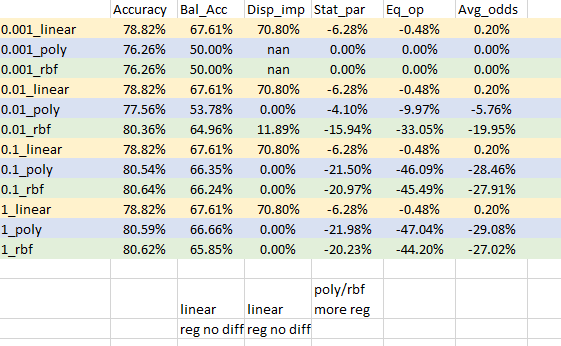

### Task 2

### Task 3